In [ ]:
import tensorflow as tf
from tensorflow import keras
import os
from PIL import Image
import numpy as np

#import Dataset

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

In [ ]:
import zipfile
import os

def extract_with_progress(zip_path, extract_path):
    # Create extraction directory if it doesn't exist
    os.makedirs(extract_path, exist_ok=True)

    # Get total number of files in the zip
    with zipfile.ZipFile(zip_path, 'r') as zip_ref:
        total_files = len(zip_ref.infolist())

    print(f"Extracting {total_files} files to: {extract_path}")

    # Extract with progress tracking and proper path handling
    with zipfile.ZipFile(zip_path, 'r') as zip_ref:
        for i, file in enumerate(zip_ref.infolist(), 1):
            # Extract each file to the specified directory
            zip_ref.extract(file.filename, extract_path)

            # Calculate and display progress
            progress = (i / total_files) * 100
            print(f"\rProgress: {progress:.1f}% ({i}/{total_files})", end='', flush=True)

    print("\nExtraction complete!")
    print(f"All files successfully extracted to: {extract_path}")

# Usage example
zip_path = "/content/drive/MyDrive/AFM dataset.zip"  # Colab path
extract_path = "/content/datasets/AFM dataset"  # Where to extract

extract_with_progress(zip_path, extract_path)

Extracting 82649 files to: /content/datasets/AFM dataset
Progress: 100.0% (82649/82649)
Extraction complete!
All files successfully extracted to: /content/datasets/AFM dataset


In [ ]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

train_dir = "/content/datasets/AFM dataset/AFM dataset/train"
test_dir = "/content/datasets/AFM dataset/AFM dataset/test"

batch_size = 256
target_size = (48, 48)
num_class = 7

datagen = ImageDataGenerator(rescale=1./255)

train_generator = datagen.flow_from_directory(
    train_dir,  # Path to the target directory
    target_size=target_size,  # Resizes all images to 48x48
    batch_size=batch_size,
    shuffle = True,
    class_mode='categorical',  # 'binary' for binary classification, 'categorical' for multi-class
    color_mode='grayscale'
)

test_generator = datagen.flow_from_directory(
    test_dir,
    target_size=target_size,
    batch_size=batch_size,
    shuffle =True,
    class_mode='categorical',
    color_mode='grayscale'
)


class_names = list(train_generator.class_indices.keys())
print("Class names:", class_names)

Found 70097 images belonging to 7 classes.
Found 12535 images belonging to 7 classes.
Class names: ['angry', 'disgust', 'fear', 'happy', 'neutral', 'sad', 'surprise']


In [ ]:
from sklearn.utils import class_weight
# Get class weights
class_weights = class_weight.compute_class_weight(
    class_weight='balanced',
    classes=np.unique(train_generator.classes),
    y=train_generator.classes
)

# Convert to dictionary
class_weights_dict = dict(enumerate(class_weights))

print(class_weights_dict)

{0: np.float64(0.9624081828791103), 1: np.float64(2.0440614702709006), 2: np.float64(1.045833644162626), 3: np.float64(0.7071433615462992), 4: np.float64(0.9439910579616462), 5: np.float64(0.8943339414894296), 6: np.float64(1.0823451300104996)}


In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import (Conv2D, MaxPooling2D, Dense, Dropout,
                                     BatchNormalization, GlobalAveragePooling2D)

model = Sequential()

model.add(Conv2D(64, (3,3), activation='relu', padding='same', input_shape=(48,48,1)))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2,2)))

model.add(Conv2D(128, (3,3), activation='relu', padding='same'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Dropout(0.3))

model.add(Conv2D(256, (3,3), activation='relu', padding='same'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Dropout(0.4))

model.add(GlobalAveragePooling2D())
model.add(Dense(512, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(num_class, activation='softmax'))

model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0005),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

model.summary()

/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_7"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_21 (Conv2D)              │ (None, 48, 48, 64)     │           640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_21          │ (None, 48, 48, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_21 (MaxPooling2D) │ (None, 24, 24, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_22 (Conv2D)              │ (None, 24, 24, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_22          │ (None, 24, 24, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_22 (MaxPooling2D) │ (None, 12, 12, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_21 (Dropout)            │ (None, 12, 12, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_23 (Conv2D)              │ (None, 12, 12, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_23          │ (None, 12, 12, 256)    │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_23 (MaxPooling2D) │ (None, 6, 6, 256)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_22 (Dropout)            │ (None, 6, 6, 256)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_7      │ (None, 256)            │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_14 (Dense)                │ (None, 512)            │       131,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_23 (Dropout)            │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_15 (Dense)                │ (None, 7)              │         3,591 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 506,631 (1.93 MB)

 Trainable params: 505,735 (1.93 MB)

 Non-trainable params: 896 (3.50 KB)

In [ ]:
from keras.callbacks import ReduceLROnPlateau
from keras.callbacks import EarlyStopping, ModelCheckpoint

checkpoint = ModelCheckpoint("/content/drive/MyDrive/FER_simple_CNN_AFM_2_without_augmentation.keras",
                             save_best_only=True, monitor="val_accuracy", mode="max")
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', patience=5, factor=0.3, min_lr=1e-6)

hist = model.fit(
    train_generator,
    epochs=200,  # Maximum number of epochs
    validation_data=test_generator,
    callbacks=[early_stopping, reduce_lr, checkpoint],
    shuffle = True,
    class_weight=class_weights_dict
)

Epoch 1/200
274/274 ━━━━━━━━━━━━━━━━━━━━ 52s 164ms/step - accuracy: 0.1880 - loss: 2.0012 - val_accuracy: 0.1517 - val_loss: 2.6388 - learning_rate: 5.0000e-04
Epoch 2/200
274/274 ━━━━━━━━━━━━━━━━━━━━ 35s 128ms/step - accuracy: 0.3449 - loss: 1.6813 - val_accuracy: 0.2337 - val_loss: 2.1858 - learning_rate: 5.0000e-04
Epoch 3/200
274/274 ━━━━━━━━━━━━━━━━━━━━ 34s 124ms/step - accuracy: 0.4158 - loss: 1.5269 - val_accuracy: 0.3722 - val_loss: 1.6299 - learning_rate: 5.0000e-04
Epoch 4/200
274/274 ━━━━━━━━━━━━━━━━━━━━ 35s 126ms/step - accuracy: 0.4489 - loss: 1.4421 - val_accuracy: 0.5048 - val_loss: 1.3120 - learning_rate: 5.0000e-04
Epoch 5/200
274/274 ━━━━━━━━━━━━━━━━━━━━ 33s 121ms/step - accuracy: 0.4817 - loss: 1.3697 - val_accuracy: 0.4744 - val_loss: 1.4152 - learning_rate: 5.0000e-04
Epoch 6/200
274/274 ━━━━━━━━━━━━━━━━━━━━ 34s 125ms/step - accuracy: 0.5047 - loss: 1.3208 - val_accuracy: 0.4707 - val_loss: 1.3913 - learning_rate: 5.0000e-04
Epoch 7/200
274/274 ━━━━━━━━━━━━━━━━━━━━

In [ ]:
early_stopping = EarlyStopping(monitor='val_loss', patience=15, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', patience=10, factor=0.3, min_lr=1e-6)

#hist = model.fit(train_images, train_labels, batch_size=256, epochs=50, shuffle=True, validation_data=(test_images, test_labels), callbacks=[early_stop, reduce_lr])

hist2 = model.fit(
    train_generator,
    # steps_per_epoch=math.ceil(train_generator.samples // train_generator.batch_size),
    epochs=50,  # Maximum number of epochs
    validation_data=test_generator,
    # validation_steps=math.ceil(test_generator.samples // test_generator.batch_size),
    callbacks=[early_stopping, reduce_lr, checkpoint],
    shuffle = True,
    class_weight=class_weights_dict
)

Epoch 1/50
274/274 ━━━━━━━━━━━━━━━━━━━━ 35s 127ms/step - accuracy: 0.6864 - loss: 0.8351 - val_accuracy: 0.6333 - val_loss: 1.0229 - learning_rate: 1.3500e-05
Epoch 2/50
274/274 ━━━━━━━━━━━━━━━━━━━━ 35s 127ms/step - accuracy: 0.6821 - loss: 0.8329 - val_accuracy: 0.6368 - val_loss: 1.0177 - learning_rate: 1.3500e-05
Epoch 3/50
274/274 ━━━━━━━━━━━━━━━━━━━━ 34s 124ms/step - accuracy: 0.6881 - loss: 0.8177 - val_accuracy: 0.6354 - val_loss: 1.0222 - learning_rate: 1.3500e-05
Epoch 4/50
274/274 ━━━━━━━━━━━━━━━━━━━━ 37s 135ms/step - accuracy: 0.6874 - loss: 0.8229 - val_accuracy: 0.6329 - val_loss: 1.0232 - learning_rate: 1.3500e-05
Epoch 5/50
274/274 ━━━━━━━━━━━━━━━━━━━━ 35s 127ms/step - accuracy: 0.6903 - loss: 0.8208 - val_accuracy: 0.6367 - val_loss: 1.0218 - learning_rate: 1.3500e-05
Epoch 6/50
274/274 ━━━━━━━━━━━━━━━━━━━━ 34s 123ms/step - accuracy: 0.6879 - loss: 0.8207 - val_accuracy: 0.6359 - val_loss: 1.0233 - learning_rate: 1.3500e-05
Epoch 7/50
274/274 ━━━━━━━━━━━━━━━━━━━━ 35s 12

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

In [ ]:
saved_model_path = '/content/drive/MyDrive'
model.save(saved_model_path + '/FER_simple_CNN_AFM_2_without_augmentation.keras', overwrite=True)
model.save(saved_model_path + '/FER_simple_CNN_AFM_2_without_augmentation.h5',overwrite=True)

In [ ]:
# Load pretrained model (if necessary)
from tensorflow.keras.models import load_model
saved_model_path = '/content/drive/MyDrive'
model = load_model(saved_model_path + '/FER_simple_CNN_AFM_2_without_augmentation.h5')

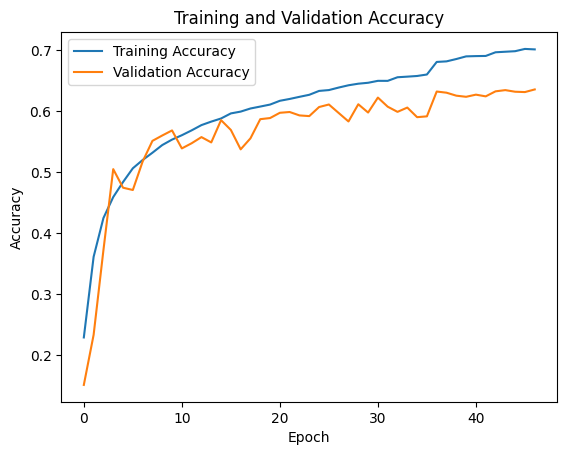

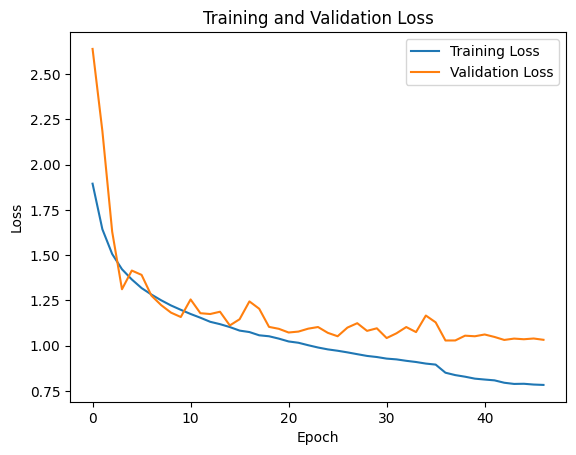

In [ ]:
import matplotlib.pyplot as plt

plt.plot(hist.history['accuracy'], label='Training Accuracy')
plt.plot(hist.history['val_accuracy'], label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

plt.plot(hist.history['loss'], label='Training Loss')
plt.plot(hist.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [ ]:
loss, accuracy = model.evaluate(test_generator)
print(f'Validation Loss: {loss}')
print(f'Validation Accuracy: {accuracy}')

49/49 ━━━━━━━━━━━━━━━━━━━━ 5s 102ms/step - accuracy: 0.6344 - loss: 1.0216
Validation Loss: 1.0176531076431274
Validation Accuracy: 0.6367770433425903


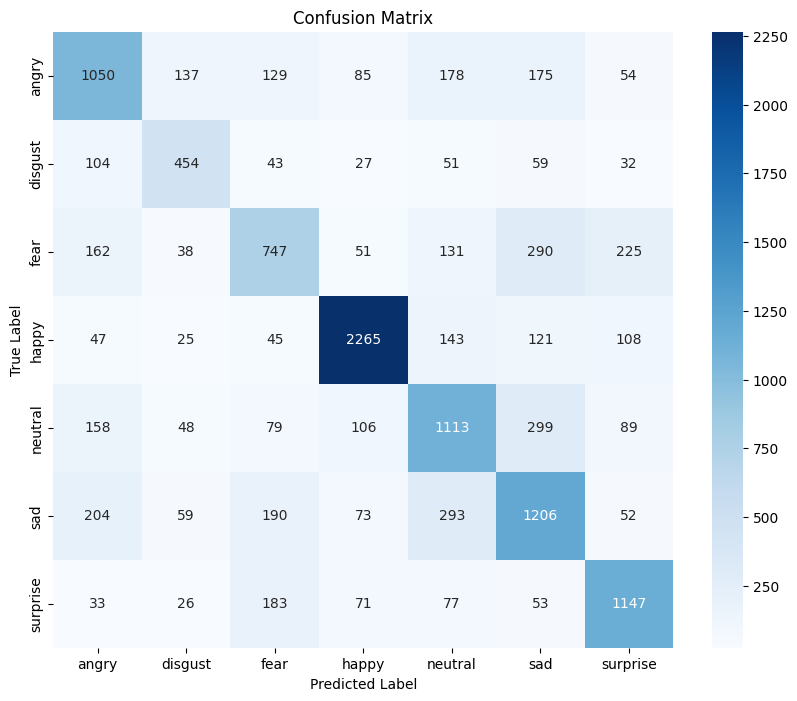


Classification Report:
              precision    recall  f1-score   support

       angry     0.5973    0.5808    0.5889      1808
     disgust     0.5769    0.5896    0.5832       770
        fear     0.5275    0.4544    0.4882      1644
       happy     0.8458    0.8224    0.8339      2754
     neutral     0.5604    0.5883    0.5740      1892
         sad     0.5474    0.5806    0.5636      2077
    surprise     0.6719    0.7214    0.6958      1590

    accuracy                         0.6368     12535
   macro avg     0.6182    0.6196    0.6182     12535
weighted avg     0.6371    0.6368    0.6363     12535


Weighted Precision: 0.6371
Weighted Recall: 0.6368
Weighted F1-Score: 0.6363


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report, precision_score, recall_score, f1_score

# Reset generator to start from the beginning
test_generator.reset()

# Initialize arrays to collect predictions and true labels
y_true = []
y_pred_classes = []

# Loop over all batches in the generator manually
for i in range(len(test_generator)):
    x_batch, y_batch = test_generator[i]

    # Predict this batch
    y_pred_batch = model.predict(x_batch, verbose=0)

    # Get predicted classes
    y_pred_classes.extend(np.argmax(y_pred_batch, axis=1))

    # Get true classes
    y_true.extend(np.argmax(y_batch, axis=1))

# Convert lists to numpy arrays
y_true = np.array(y_true)
y_pred_classes = np.array(y_pred_classes)

# Class names from the generator
class_names = list(test_generator.class_indices.keys())

# Plot confusion matrix
conf_matrix = confusion_matrix(y_true, y_pred_classes)
plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues',
            xticklabels=class_names, yticklabels=class_names)
plt.title('Confusion Matrix')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()

# Print classification report
print("\nClassification Report:")
print(classification_report(y_true, y_pred_classes, target_names=class_names, digits=4))

# Print weighted precision, recall, and F1-score
precision = precision_score(y_true, y_pred_classes, average='weighted')
recall = recall_score(y_true, y_pred_classes, average='weighted')
f1 = f1_score(y_true, y_pred_classes, average='weighted')

print(f"\nWeighted Precision: {precision:.4f}")
print(f"Weighted Recall: {recall:.4f}")
print(f"Weighted F1-Score: {f1:.4f}")
